In [3]:
library(dplyr)
library(tidyverse)
library(RColorBrewer)
library(GGally)
library(mltools)
library(leaps)

ERROR: Error in library(mltools): there is no package called ‘mltools’


## Introduction

We will be using the sleep efficiency dataset:

https://www.kaggle.com/datasets/equilibriumm/sleep-efficiency in Kaggle, which contains 100 observations.

The data was collected in 2021 by a research team in the UK, and was collected from the University of Oxfordshire. It was collected from a local community over a period of several months using a combination of self-reported surveys, actigraphy, and polysomnography (a sleep monitoring technique). 

**Our research question and motivation behind the analysis of the data:**

Which variables are most important in predicting sleep efficiency? And how do these variables relate to sleep efficiency?

We use a forward selection process to determine which variables are most relevant for predicting sleep efficiency and build regression models based only on the variables selected. After comparing different models, we select the best model and use this model to predict the test dataset and combine it with the actual values to see how accurate our model is.

From the model, we can develop a general idea about what factors relate to sleep efficiency and how they are correlated. Therefore, it may suggest some methods to improve sleep patterns by controlling certain factors. 

In [6]:
sleep <- read.csv('Sleep_Efficiency.csv')

# Convert certain variables into categorical variables 
# Gender: male is encoded as 1, and female is encoded as 0
# Smoking status: Yes is encoded as 1, and No is encoded as 0
sleep <- sleep |>
    mutate(Caffeine.consumption = as.factor(Caffeine.consumption),
          Awakenings = as.factor(Awakenings),
          Alcohol.consumption = as.factor(Alcohol.consumption), 
          Smoking.status = as.factor(case_when(
              Smoking.status == 'Yes' ~ 1,
              Smoking.status == 'No' ~ 0,
              TRUE ~ NA)),
           Gender= as.factor(case_when(
              Gender == 'Male' ~ 1,
              Gender == 'Female' ~ 0,
              TRUE ~ NA)),
           Exercise.frequency = as.factor(Exercise.frequency)
          )

head(sleep)

,ID,Age,Gender,Bedtime,Wakeup.time,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Light.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<int>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,1,65,0,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0,0,0,1,3
2,2,69,1,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3,0,3,1,3
3,3,40,0,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1,0,0,0,3
4,4,40,0,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3,50,5,1,1
5,5,57,1,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3,0,3,0,3
6,6,36,0,2021-07-01 21:00:00,2021-07-01 04:30:00,7.5,0.90,23,60,17,0,NA,0,0,1


We included 12 variables:

*The response variable:*

>Sleep efficiency: a numerical variable ranging from 0 to 1 that indicates the proportion of time in bed spent asleep

*The explanatory variables:*

>1. Age: numerical variable ranges from 9 to 69
>2. Gender: categorical / dummy variable with 50% of the data is male and the rest half female
>3. Sleep duration: numerical variable indicating the total amount of time the test subject slept (in hours).
>4. Awakenings: categorical variable indicating the number of times the test subject wakes up during the night
>5. REM sleep percentage: numerical variable indicating the percentage of total sleep time spent in REM (rapid eye movement) sleep 
    - REM sleep is the stage where people have intense brain activities (dreams) and restores the areas of the brain that help with memory and learning. 20% of the total sleep time in the REM stage is considered good 
>6. Deep sleep percentage: numerical variable indicating the percentage of total sleep time spent in Deep (non - rapid eye movement) sleep 
    - Deep sleep is important for body to replenish energy stores and repair muscles, bones, and tissue. 15% to 25% of the total sleep time in the deep sleep stage is considered normal  
>7. Light sleep percentage:  numerical variable indicating the percentage of total sleep time spent in Light sleep
    - Light sleep is the transitional stage between waking and sleeping. Typically take up about 50% to 60% or more of the total sleep time     
>8. Caffeine consumption: categorical variable indicating the amount of caffeine consumed in the 24 hours prior to bedtime (in mg)
>9. Alcohol consumption: categorical variable indicating the amount of alcohol consumed in the 24 hours prior to bedtime (in oz)
>10. Smoking status: categorical / dummy variable that states whether or not the person smokes
>11. Exercise frequency: categorical variable indicating the number of times the person exercises each week

Although some explanatory variables appear as numerical (e.g. Alcohol consumption, Caffeine consumption), the number of values these variables take are limited. Therefore, we can view these variables as categorical with a few levels. 

In [7]:
sleep_data <- sleep |>
    select(-ID, -Bedtime, -Wakeup.time, -Light.sleep.percentage)
head(sleep_data)

,Age,Gender,Sleep.duration,Sleep.efficiency,REM.sleep.percentage,Deep.sleep.percentage,Awakenings,Caffeine.consumption,Alcohol.consumption,Smoking.status,Exercise.frequency
,<int>,<fct>,<dbl>,<dbl>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,65,0,6.0,0.88,18,70,0,0,0,1,3
2,69,1,7.0,0.66,19,28,3,0,3,1,3
3,40,0,8.0,0.89,20,70,1,0,0,0,3
4,40,0,6.0,0.51,23,25,3,50,5,1,1
5,57,1,8.0,0.76,27,55,3,0,3,0,3
6,36,0,7.5,0.90,23,60,0,NA,0,0,1


In [8]:
set.seed(123)

train_ind <- sample.int(nrow(sleep_data), size = nrow(sleep_data) * 0.70, replace = FALSE)

sleep_train <- sleep_data[train_ind,]
sleep_test <- sleep_data[-train_ind,]

In [9]:
options(repr.plot.height = 15, repr.plot.width = 15)
sleep_train |>
    ggpairs(columns = c('Age', 'Sleep.duration', 'Sleep.efficiency', 'REM.sleep.percentage', 'Deep.sleep.percentage', 'Light.sleep.percentage'))

ERROR: Error in fix_column_values(data, columns, columnLabels, "columns", "columnLabels"): Columns in 'columns' not found in data: c('Light.sleep.percentage'). Choices: c('Age', 'Gender', 'Sleep.duration', 'Sleep.efficiency', 'REM.sleep.percentage', 'Deep.sleep.percentage', 'Awakenings', 'Caffeine.consumption', 'Alcohol.consumption', 'Smoking.status', 'Exercise.frequency')


Looking at this ggpairs graph which only includes the numerical variables, we see that only deep sleep percentage and light sleep percentage are strongly correlated with the reponse variable (sleep efficiency). Their correlation are 0.804 and -0.833 respectively. 

Almost all the explanatory variables have no significant correlation with each other except deep sleep percentage and light sleep percentage. These two variables have a very strong correlation that is -0.976, and their correspong scatterplot also exbihits a strong negative linear relationship. This could result in a very problematic issue called collinearity. 

Therefore, we will perform a forward selection process to determine which set of variables will be included in the model building.  

Let's start by making a full model regression to have a comparison between our final selected model.

Now we can begin the forward selection process.
We also will compute values of RSS, BIC, and Cp to help decide which sized model is the best fit.

In [10]:
#Model Construction part:

In [11]:
#We did a full regression that include all variables(except Light.sleep.percentage because of the colliearity.)

In [12]:
full_regression <- lm(Sleep.efficiency ~., data = sleep_train)
summary(full_regression)


Call:
lm(formula = Sleep.efficiency ~ ., data = sleep_train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.154610 -0.030602  0.004364  0.036608  0.120634 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              0.4141555  0.0485617   8.528 1.55e-15 ***
Age                      0.0009565  0.0002794   3.424 0.000723 ***
Gender1                 -0.0028553  0.0093232  -0.306 0.759670    
Sleep.duration           0.0010492  0.0040265   0.261 0.794632    
REM.sleep.percentage     0.0059326  0.0011335   5.234 3.57e-07 ***
Deep.sleep.percentage    0.0052323  0.0002854  18.336  < 2e-16 ***
Awakenings1             -0.0499841  0.0097143  -5.145 5.47e-07 ***
Awakenings2             -0.1228213  0.0136100  -9.024  < 2e-16 ***
Awakenings3             -0.1203514  0.0124563  -9.662  < 2e-16 ***
Awakenings4             -0.1194693  0.0128669  -9.285  < 2e-16 ***
Caffeine.consumption25  -0.0002236  0.0117032  -0.019 0.984771    
Caffe

In [13]:
#According to the summary, we found there should be 8 variables include.
#Our assumption is there should be:Age,REM sleep percentage,Deep sleep percentage,Awakenings(1~4) and smoking status.
#We choose to ignore Caffeine, Alcohol and Exercise since only one or two levels of them are included. We do not think it is reasonable.

In [14]:
#Here we did a rmse calculation to make a comparison between the full model and selected model later.

In [15]:
full_reg_pred <- predict(full_regression, newdata = sleep_test)

sleep_R_MSE_models <- tibble(
  Model = "Full Regression",
  R_MSE = rmse(
    preds = full_reg_pred,
    actual = sleep_test$Sleep.efficiency,
    na.rm=TRUE))

sleep_R_MSE_models

ERROR: Error in rmse(preds = full_reg_pred, actual = sleep_test$Sleep.efficiency, : could not find function "rmse"


In [16]:
#The result is 0.0563, we saved it and also the adj_rsq=0.8301.

In [17]:
#The forward selection begins, 

In [18]:
sleep_forward_selection <- regsubsets(
  x = Sleep.efficiency ~., nvmax = 11,
  data = sleep_train,
  method = "forward")
sleep_forward_summary <- summary(sleep_forward_selection)
sleep_forward_summary_df <- tibble(
  n_input_variables = 1:11,
  RSS = sleep_forward_summary$rss,
  BIC = sleep_forward_summary$bic,
  Cp = sleep_forward_summary$cp,
  R_squared=sleep_forward_summary$rsq)
sleep_forward_summary_df

ERROR: Error in regsubsets(x = Sleep.efficiency ~ ., nvmax = 11, data = sleep_train, : could not find function "regsubsets"


In [19]:
#We see that as the number of variables increase, the rsq is approaching 1, and cp is getting lower.

In [20]:
summary(sleep_forward_selection)

ERROR: Error in summary(sleep_forward_selection): object 'sleep_forward_selection' not found


In [21]:
#Form the summary, we see if our expectation is 8 variables, then the result of forward selection gives us the same answer.

In [ ]:
#make the model with our selection.

In [22]:
sleep_selected_regression <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                                + Awakenings + Smoking.status 
                                , data = sleep_train)
summary(sleep_selected_regression)


Call:
lm(formula = Sleep.efficiency ~ Age + REM.sleep.percentage + 
    Deep.sleep.percentage + Awakenings + Smoking.status, data = sleep_train)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.154580 -0.038760  0.004589  0.040481  0.126225 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            0.3936206  0.0324933  12.114  < 2e-16 ***
Age                    0.0009431  0.0002577   3.660 0.000299 ***
REM.sleep.percentage   0.0066681  0.0009817   6.792 6.09e-11 ***
Deep.sleep.percentage  0.0055981  0.0002499  22.404  < 2e-16 ***
Awakenings1           -0.0551456  0.0094017  -5.866 1.20e-08 ***
Awakenings2           -0.1259112  0.0129941  -9.690  < 2e-16 ***
Awakenings3           -0.1311739  0.0118869 -11.035  < 2e-16 ***
Awakenings4           -0.1358205  0.0121741 -11.157  < 2e-16 ***
Smoking.status1       -0.0414836  0.0073370  -5.654 3.70e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residua

In [23]:
#Although the adj_rsq decrease a little, we can see each variable has a p-value<5%.

In [24]:
#Now fit a predicted model

In [25]:
sleep_selected_reg_pred <- predict(sleep_selected_regression, newdata = sleep_test)

In [26]:
#Now we can compare the RMSE on the models

In [27]:
sleep_R_MSE_models <- rbind(
  sleep_R_MSE_models,
  tibble(
    Model = "Selected Regression",
    R_MSE = rmse(
      preds = sleep_selected_reg_pred,
      actuals = sleep_test$Sleep.efficiency,
      na.rm = TRUE)))
sleep_R_MSE_models

ERROR: Error in rbind(sleep_R_MSE_models, tibble(Model = "Selected Regression", : object 'sleep_R_MSE_models' not found


In [28]:
#Full regression has a RMSE=0.0563 and Selected Regression has a RMSE=0.0543.
#By comparing rmse our new selected regression will be better.

In [ ]:
#We also tried to add some interaction terms to explore some potential relationship:
#Here we creat interactions of age and other variables and split them into 4 different models.
#The reason why we choose Age is we consider a lot of factors maybe affected by age.
#For example, the damage of smoking maybe various for people in different ages.

In [ ]:
sleep_inter1 <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                                + Awakenings + Smoking.status + Age*Smoking.status
                                , data = sleep_train)
summary(sleep_inter1)

sleep_inter2 <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                   + Awakenings + Smoking.status + Age*REM.sleep.percentage
                   , data = sleep_train)
summary(sleep_inter2)

sleep_inter3 <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                   + Awakenings + Smoking.status + Age*Deep.sleep.percentage
                   , data = sleep_train)
summary(sleep_inter3)

sleep_inter4 <- lm(Sleep.efficiency ~ Age + REM.sleep.percentage + Deep.sleep.percentage
                   + Awakenings + Smoking.status + Age*Awakenings
                   , data = sleep_train)
summary(sleep_inter4)

In [ ]:
#However, the results are not as we expect, all interaction terms cannot pass the significance test.

In [ ]:
#fit a predicted model
sleep_selected_reg_pred <- predict(sleep_selected_regression, newdata = sleep_test)
sleep_inter1_pred <- predict(sleep_inter1,newdata = sleep_test)
sleep_inter2_pred <- predict(sleep_inter2,newdata = sleep_test)
sleep_inter3_pred <- predict(sleep_inter3,newdata = sleep_test)
sleep_inter4_pred <- predict(sleep_inter4,newdata = sleep_test)

In [ ]:
#Now we can compare the RMSE on the models
sleep_R_MSE_models <- rbind(
  tibble(
    Model = "Selected Regression",
    R_MSE = rmse(
      preds = sleep_selected_reg_pred,
      actuals = sleep_test$Sleep.efficiency,
      na.rm = TRUE)),
 tibble(
  Model = "inter1 Regression",
  R_MSE = rmse(
    preds = sleep_inter1_pred,
    actuals = sleep_test$Sleep.efficiency,
    na.rm = TRUE)),
 tibble(
  Model = "inter2 Regression",
  R_MSE = rmse(
    preds = sleep_inter2_pred,
    actuals = sleep_test$Sleep.efficiency,
    na.rm = TRUE)),
 tibble(
  Model = "inter3 Regression",
  R_MSE = rmse(
    preds = sleep_inter3_pred,
    actuals = sleep_test$Sleep.efficiency,
    na.rm = TRUE)),
 tibble(
  Model = "inter4 Regression",
  R_MSE = rmse(
    preds = sleep_inter4_pred,
    actuals = sleep_test$Sleep.efficiency,
    na.rm = TRUE)))

sleep_R_MSE_models

In [ ]:
#By comparing rmse amond inter_models we see that inter1 and 2 have the highest rmse and 3,4 seem to have similar rmse to selected model.
#So we conjecture maybe interaction terms do not really matter. But there is one interesting thing we found that inter3 model has the highest rsq among all non-full
#regression models although the ineraction term Age*Deep.sleep.percentage do not have an ideal significance.

Warning message:
“not plotting observations with leverage one:
  228, 263”


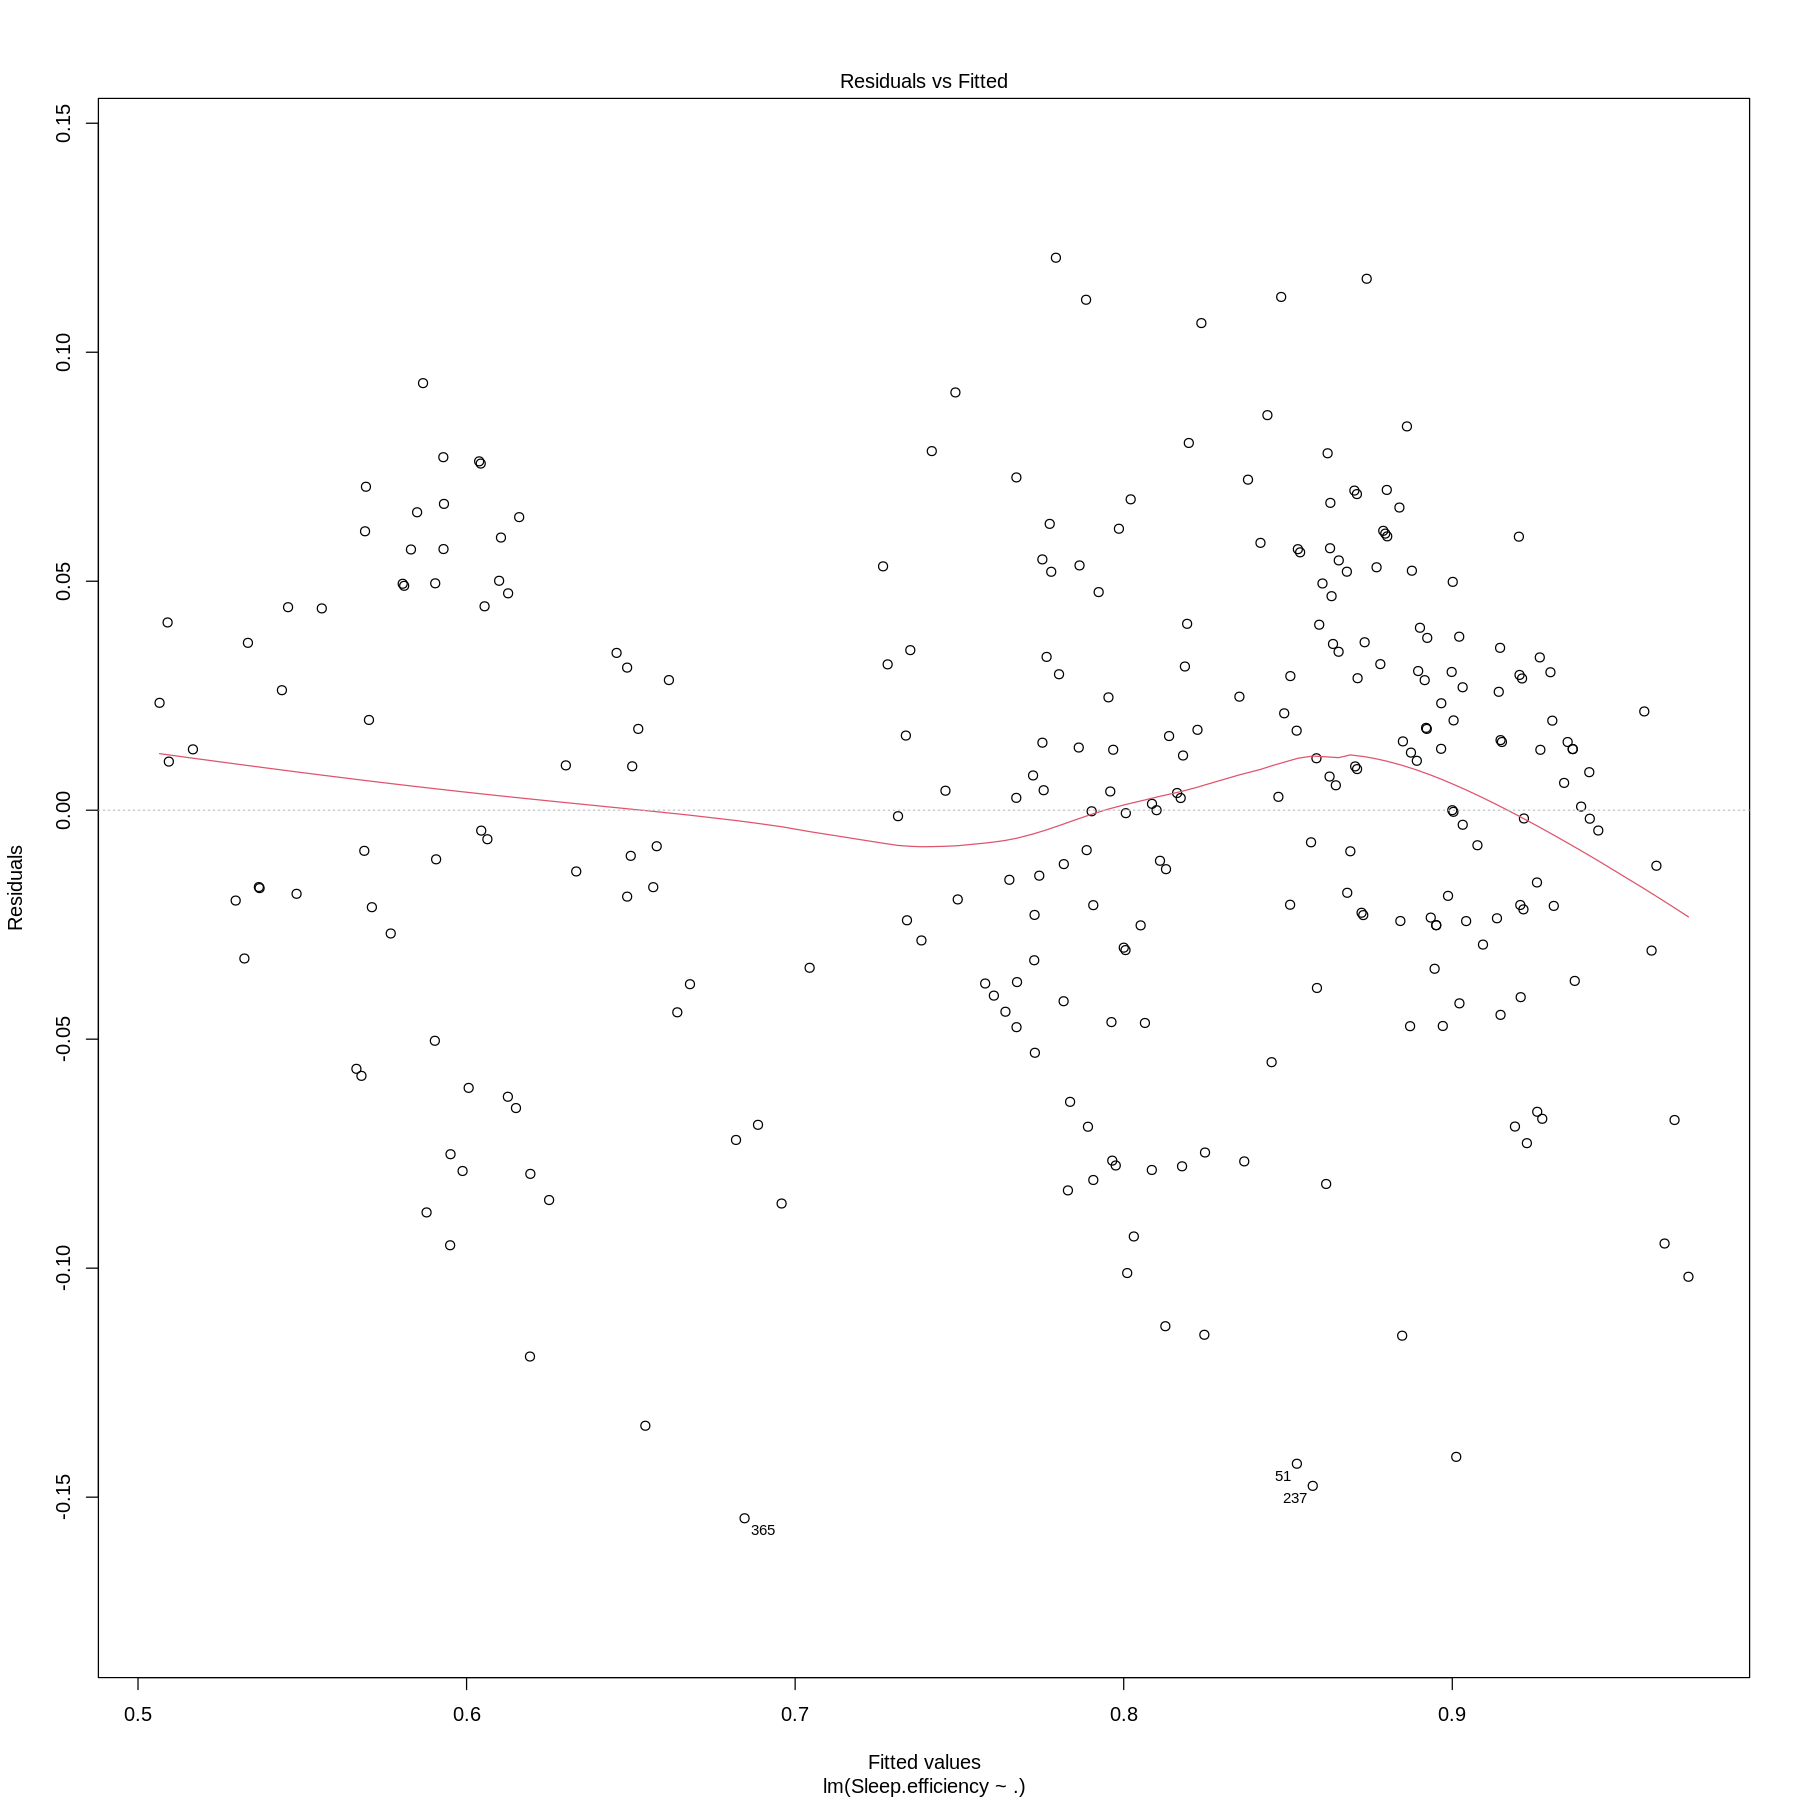

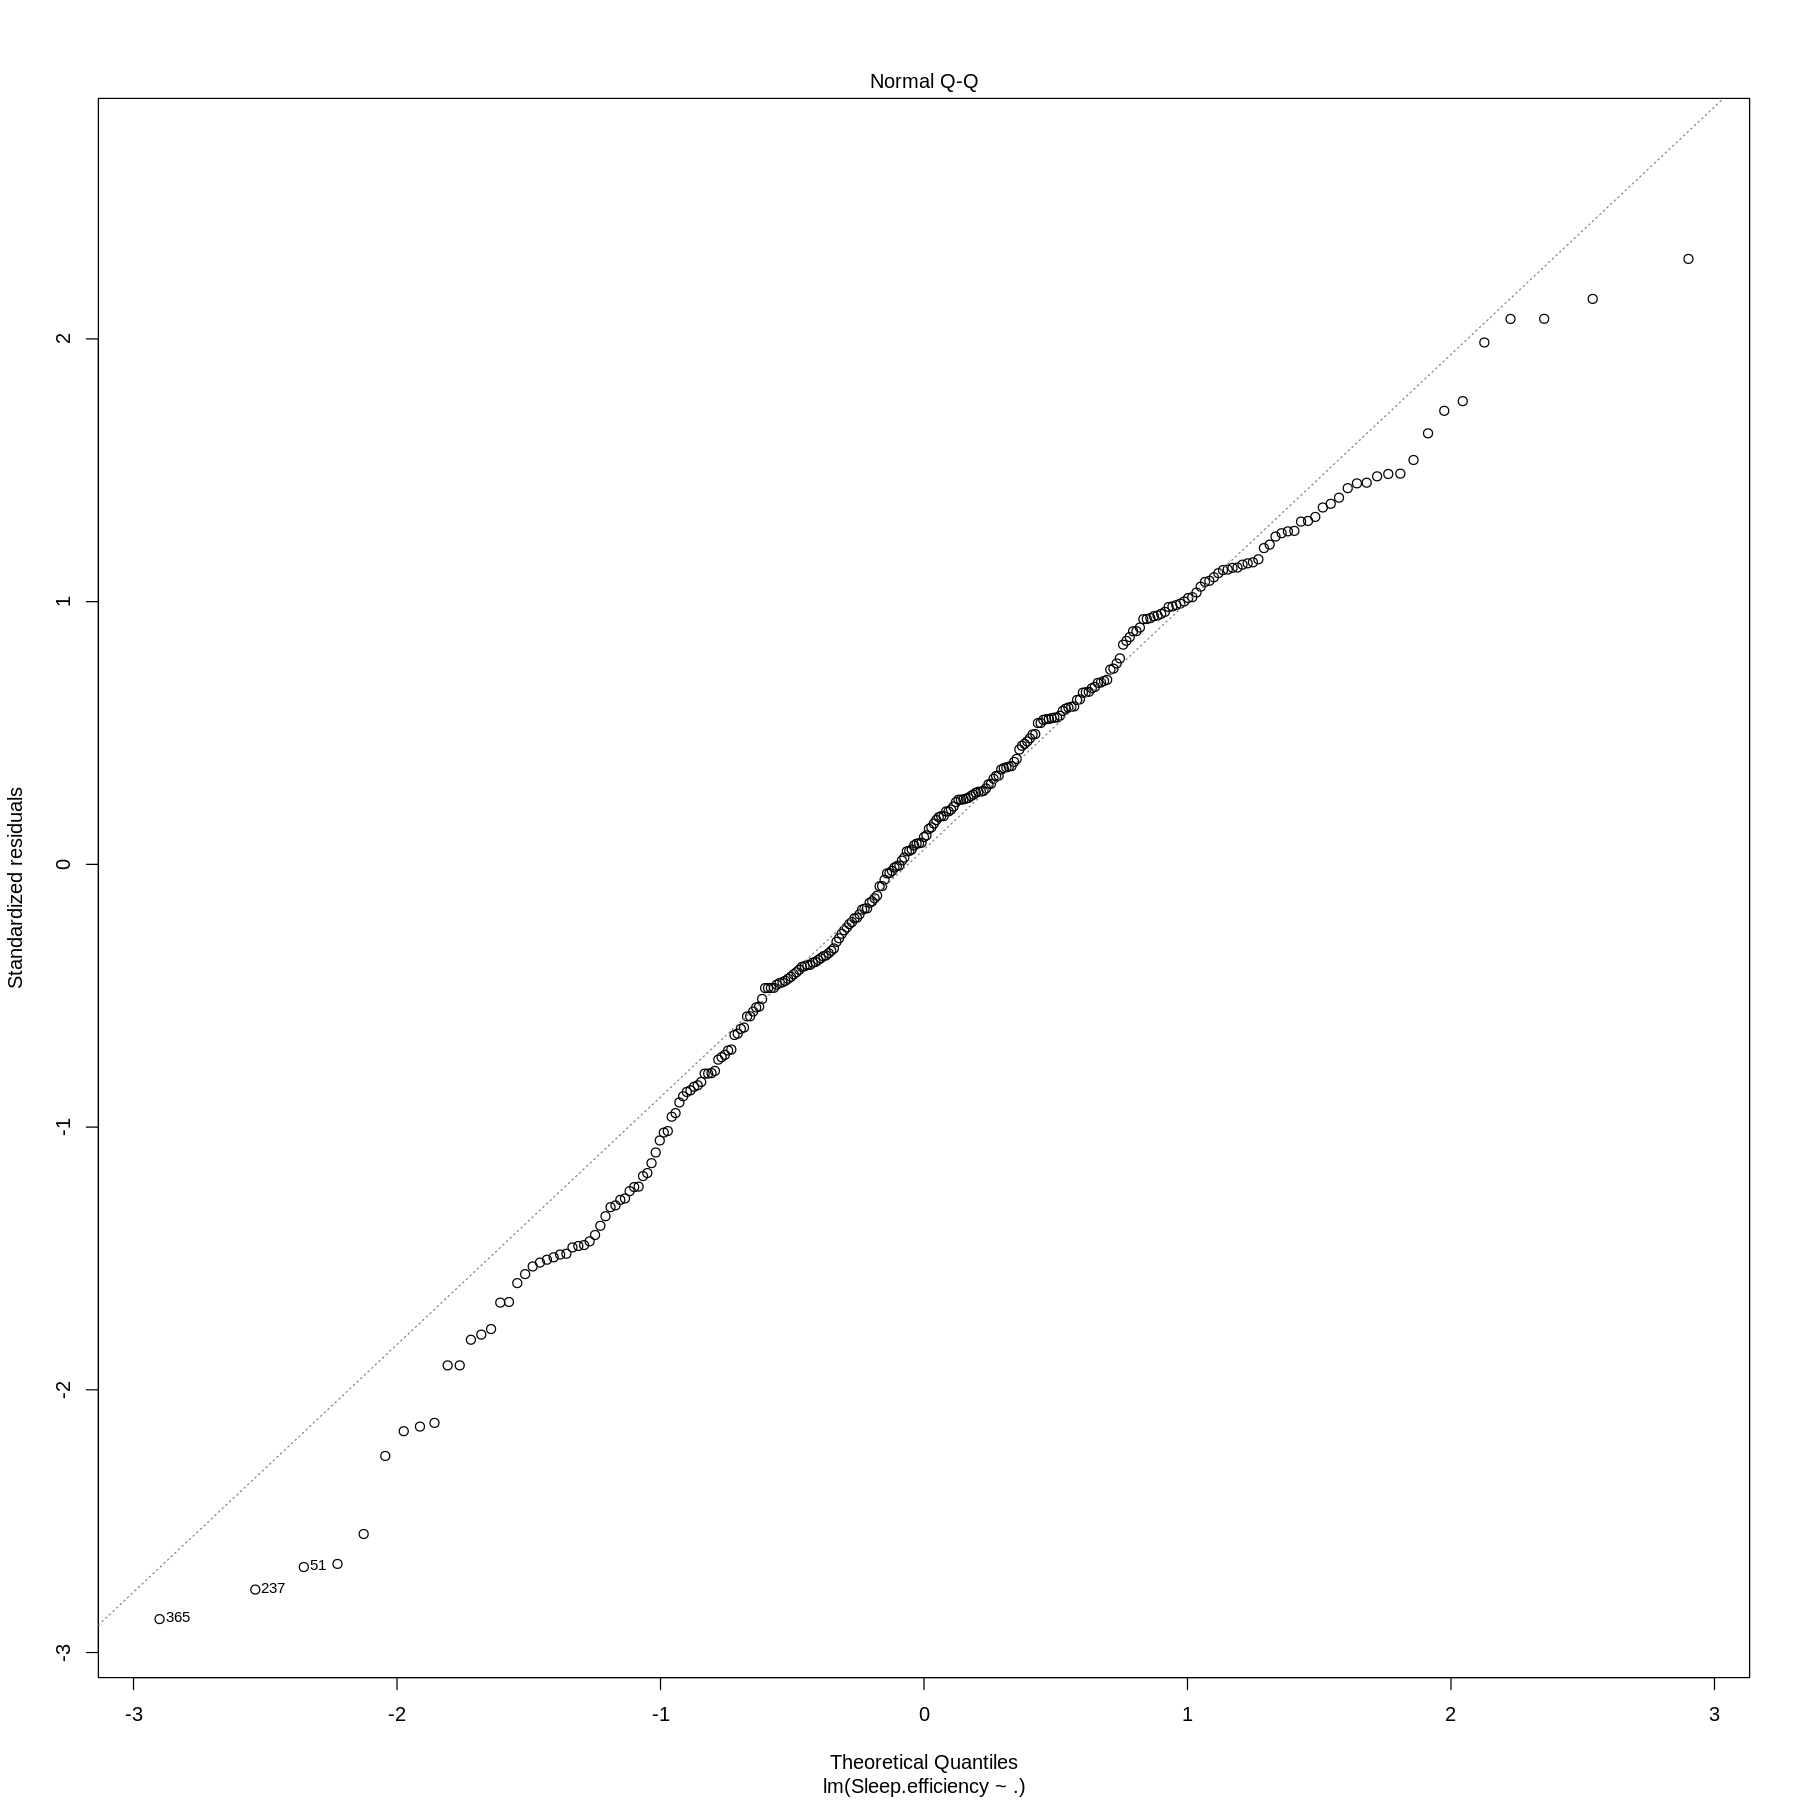

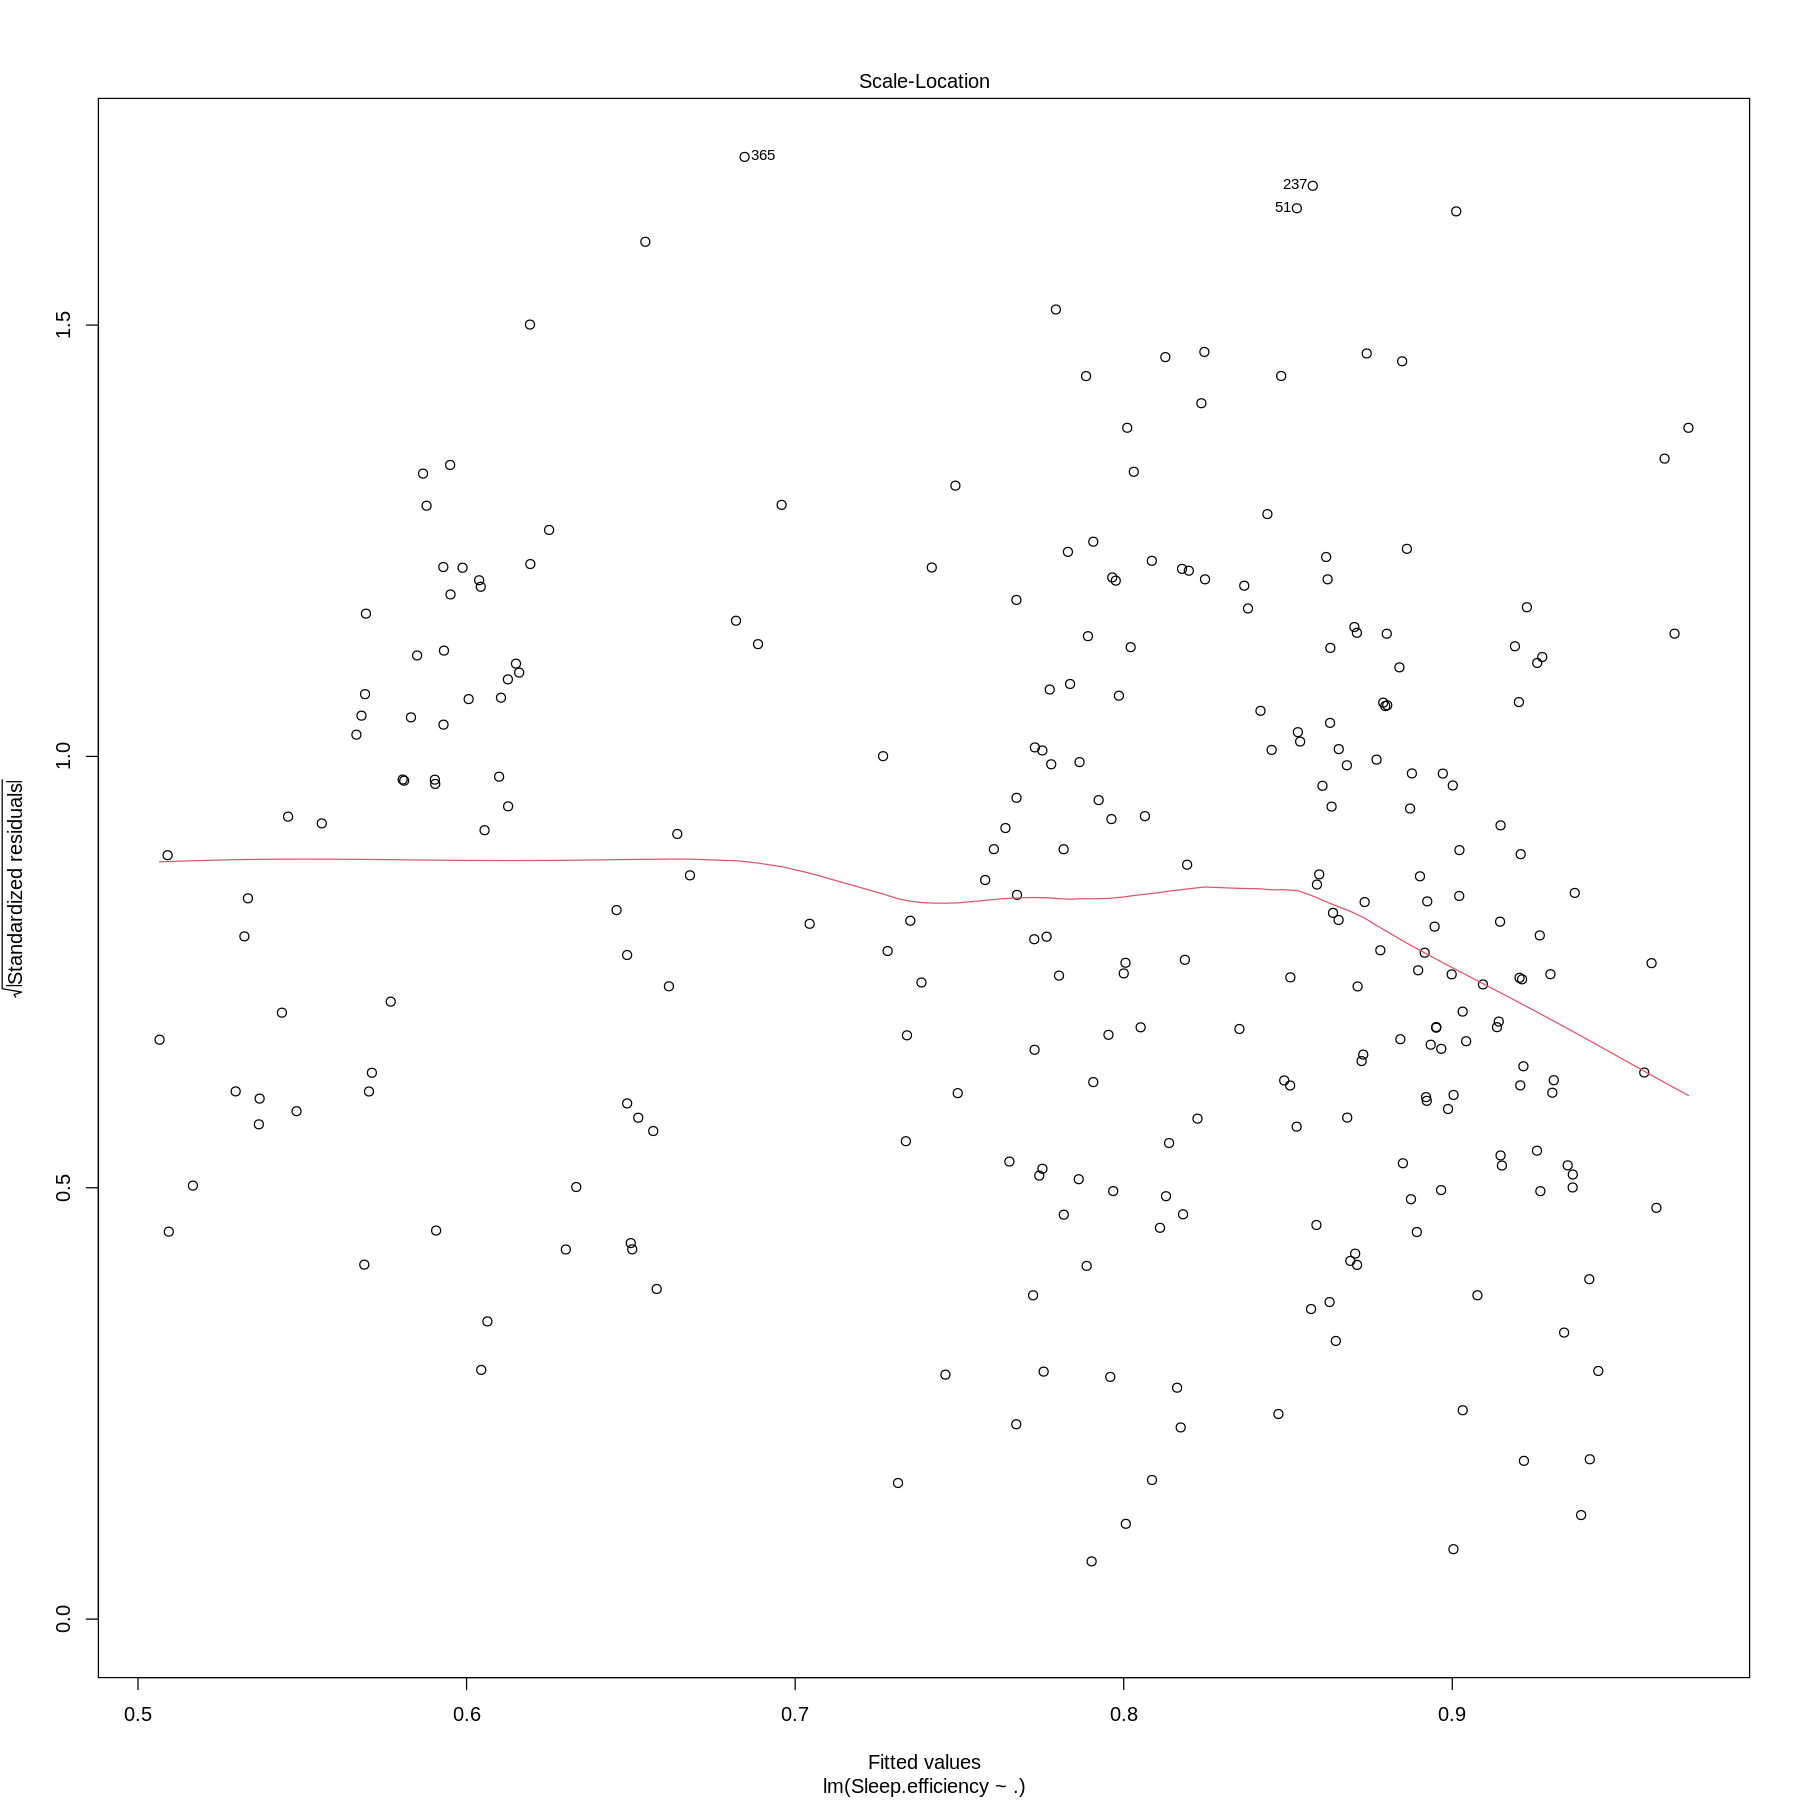

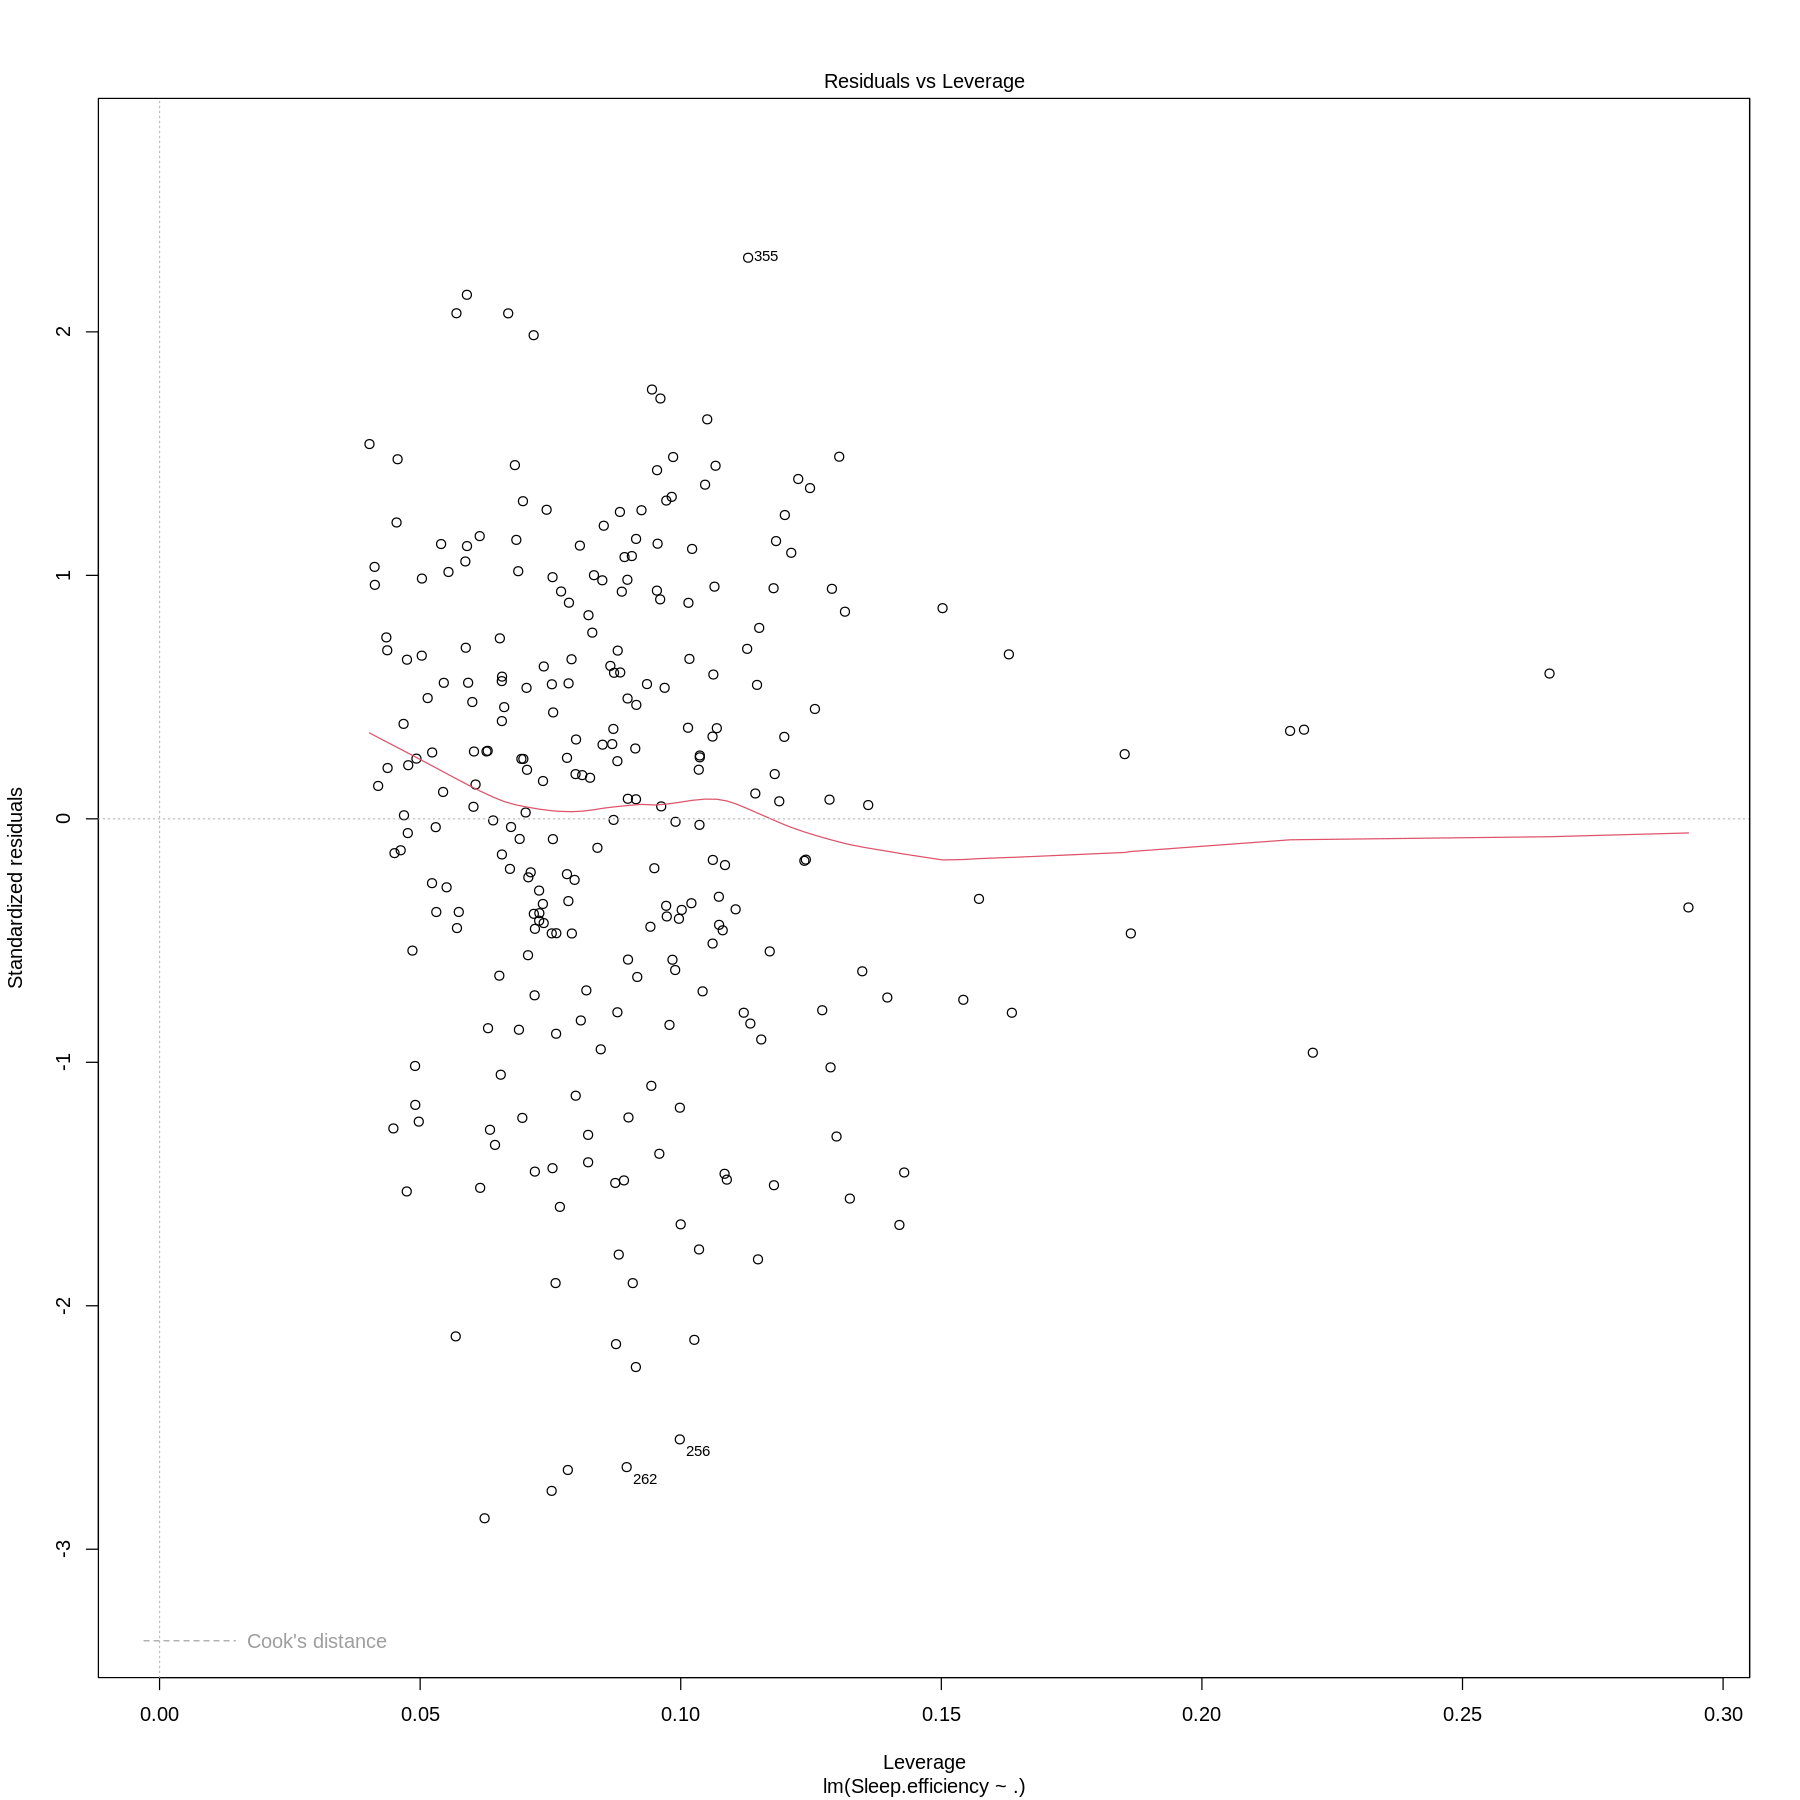

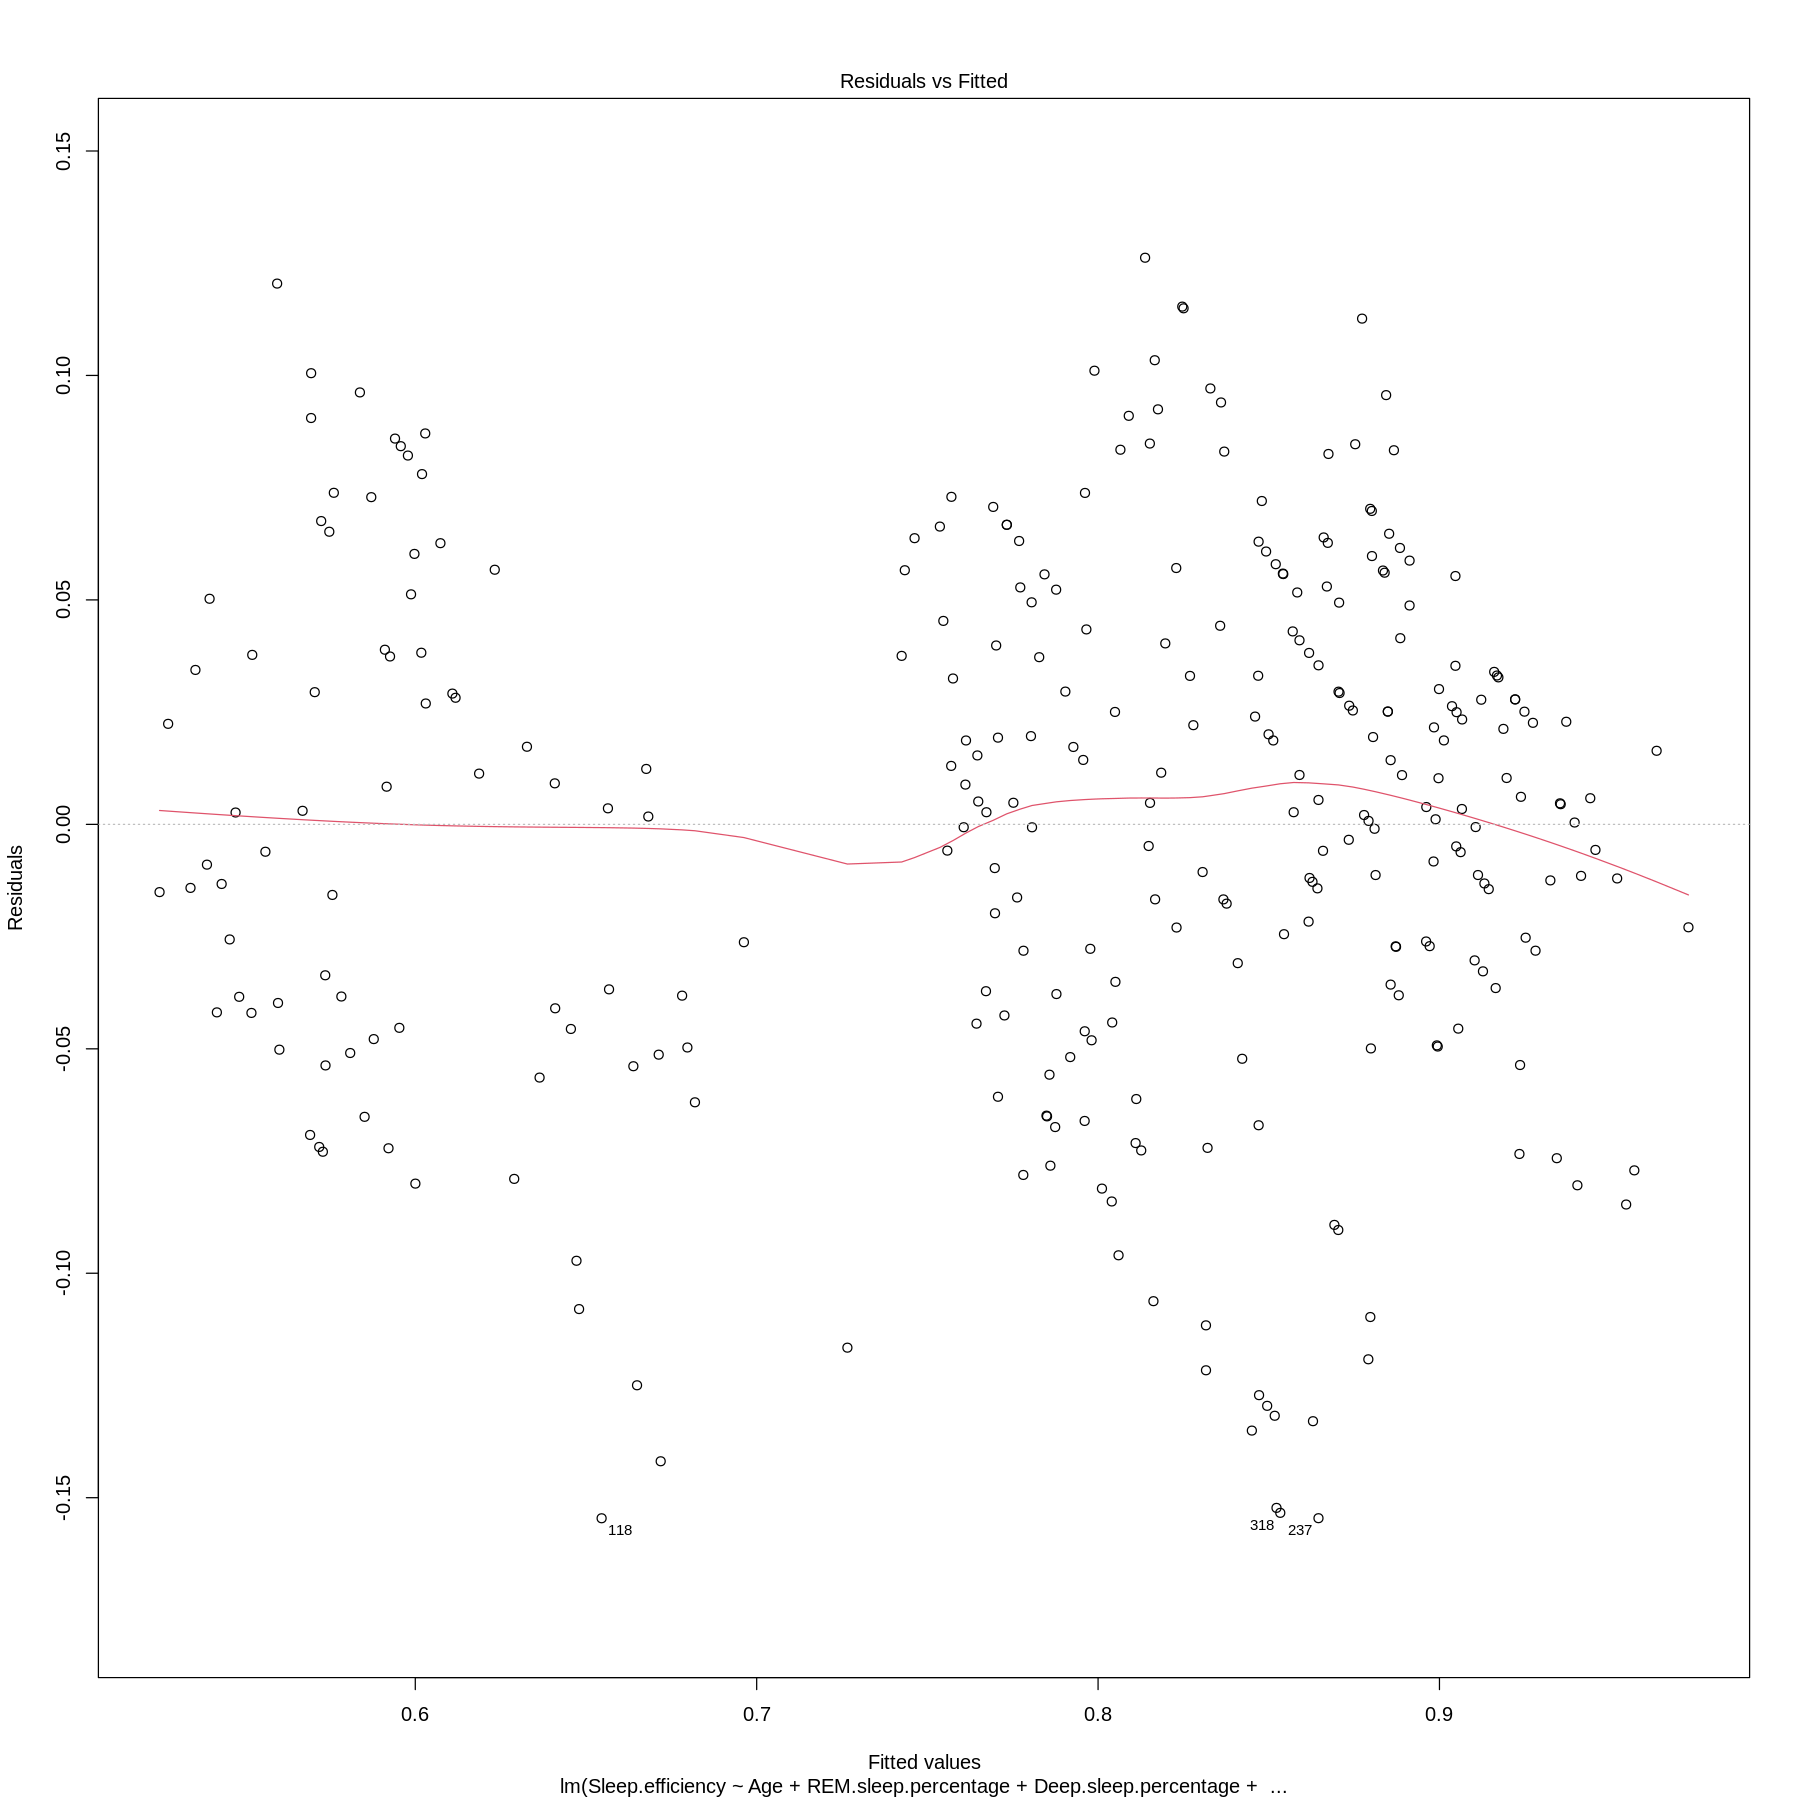

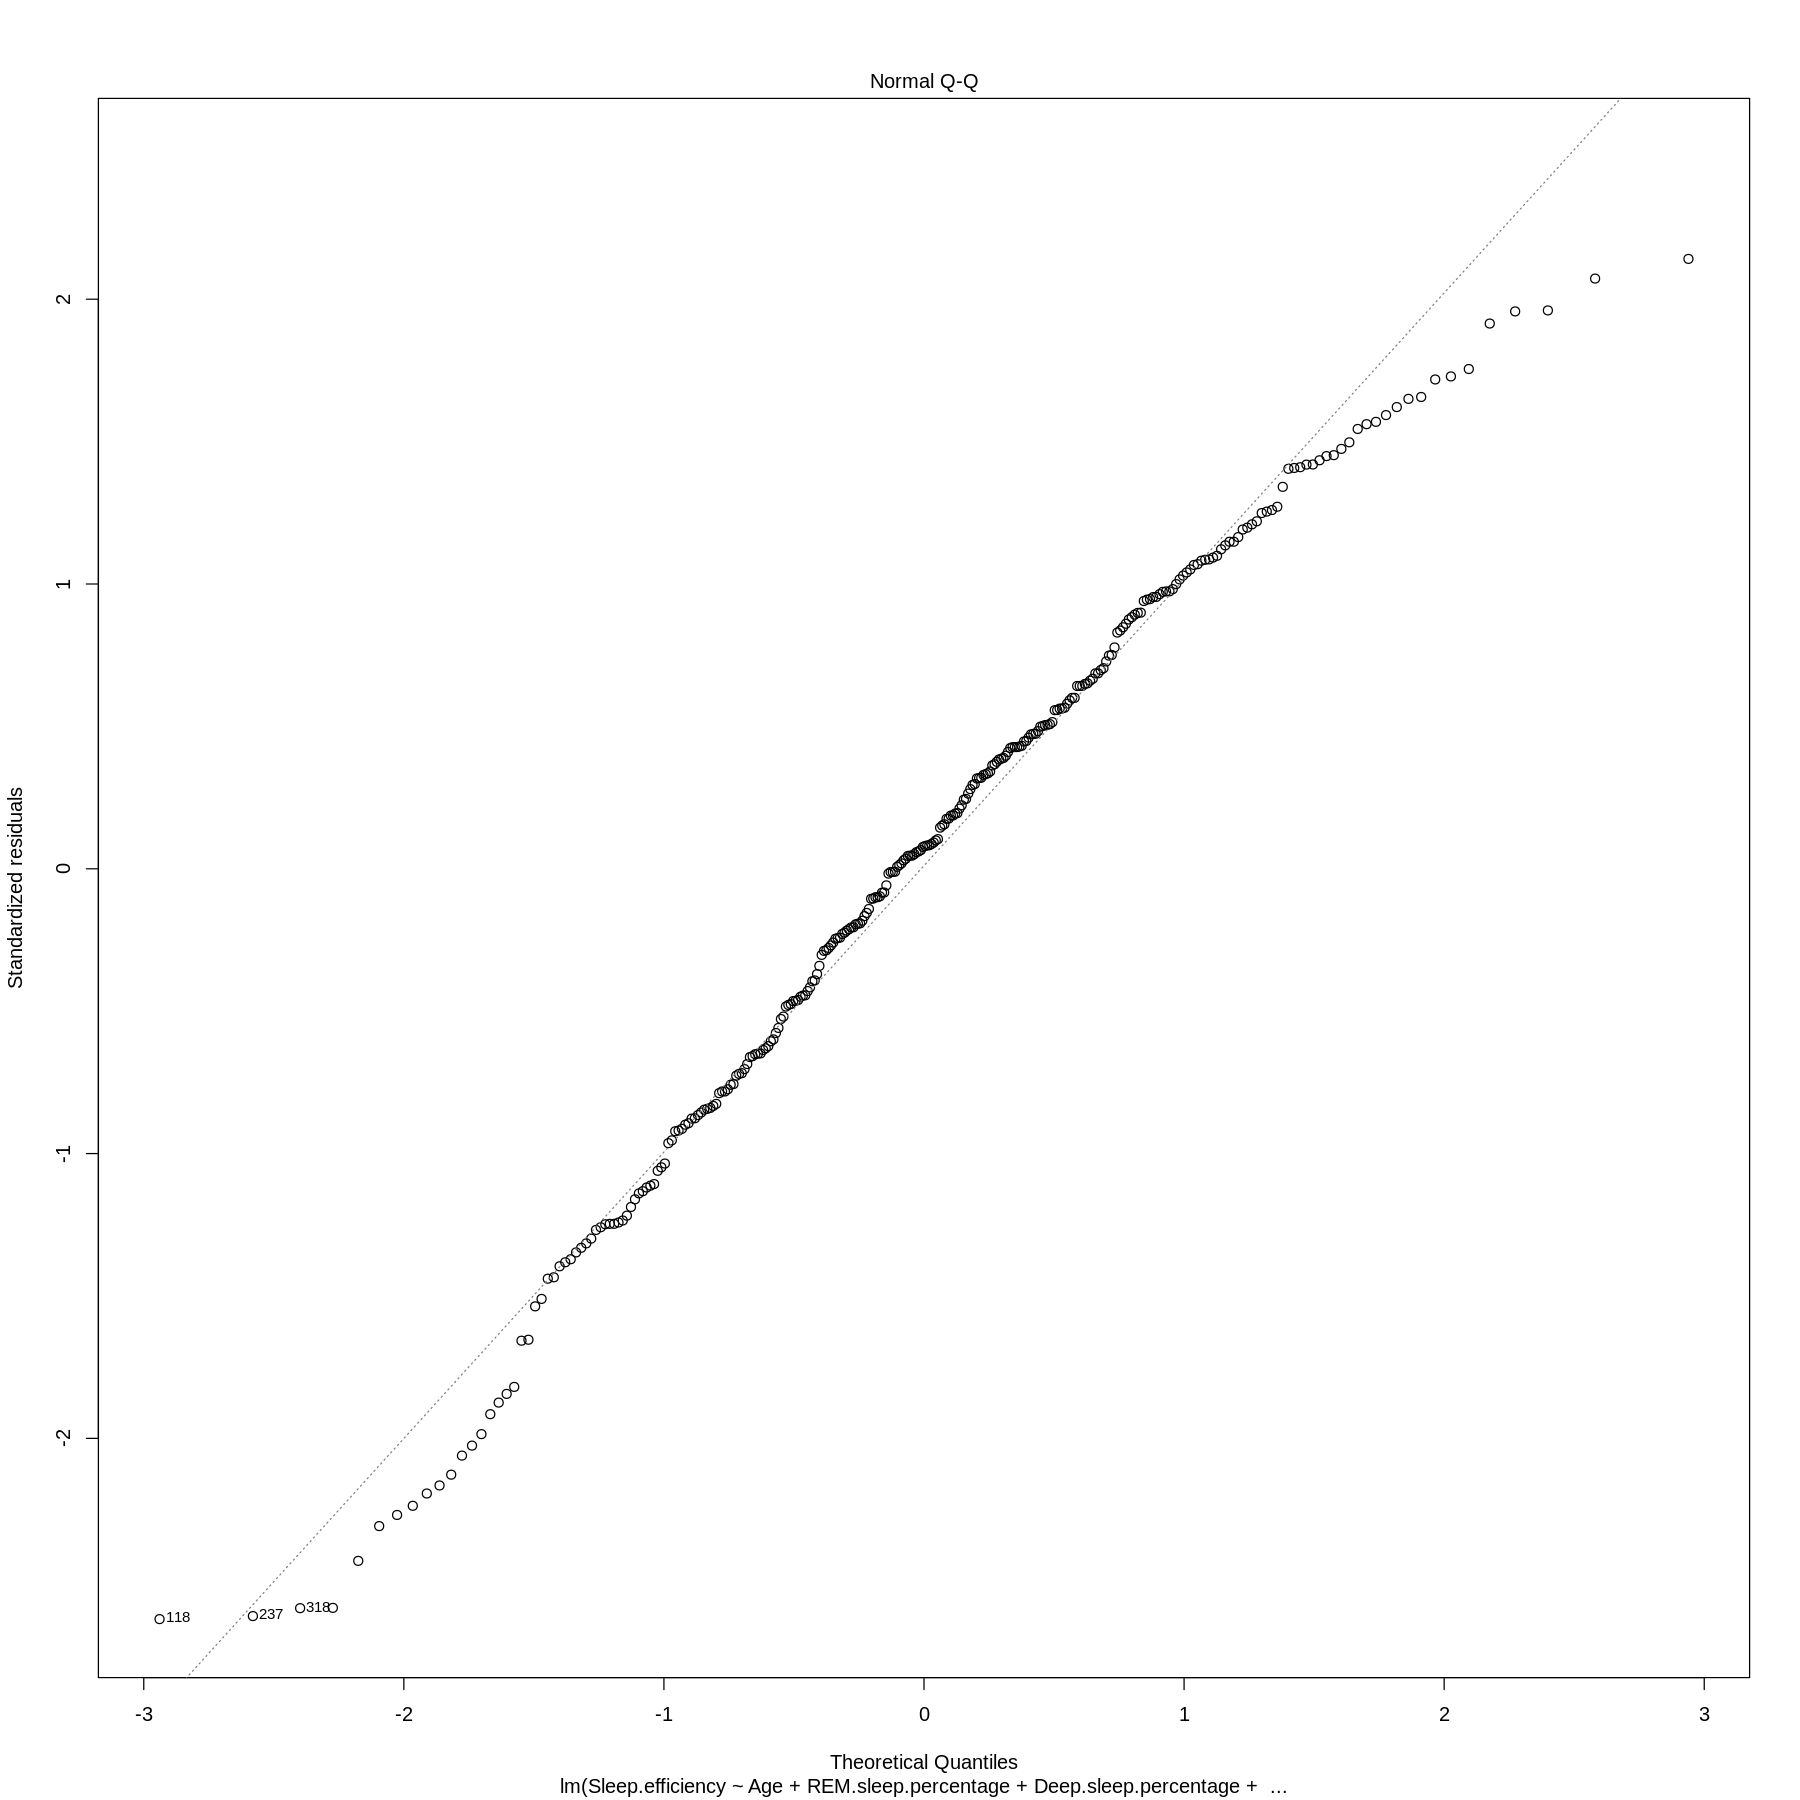

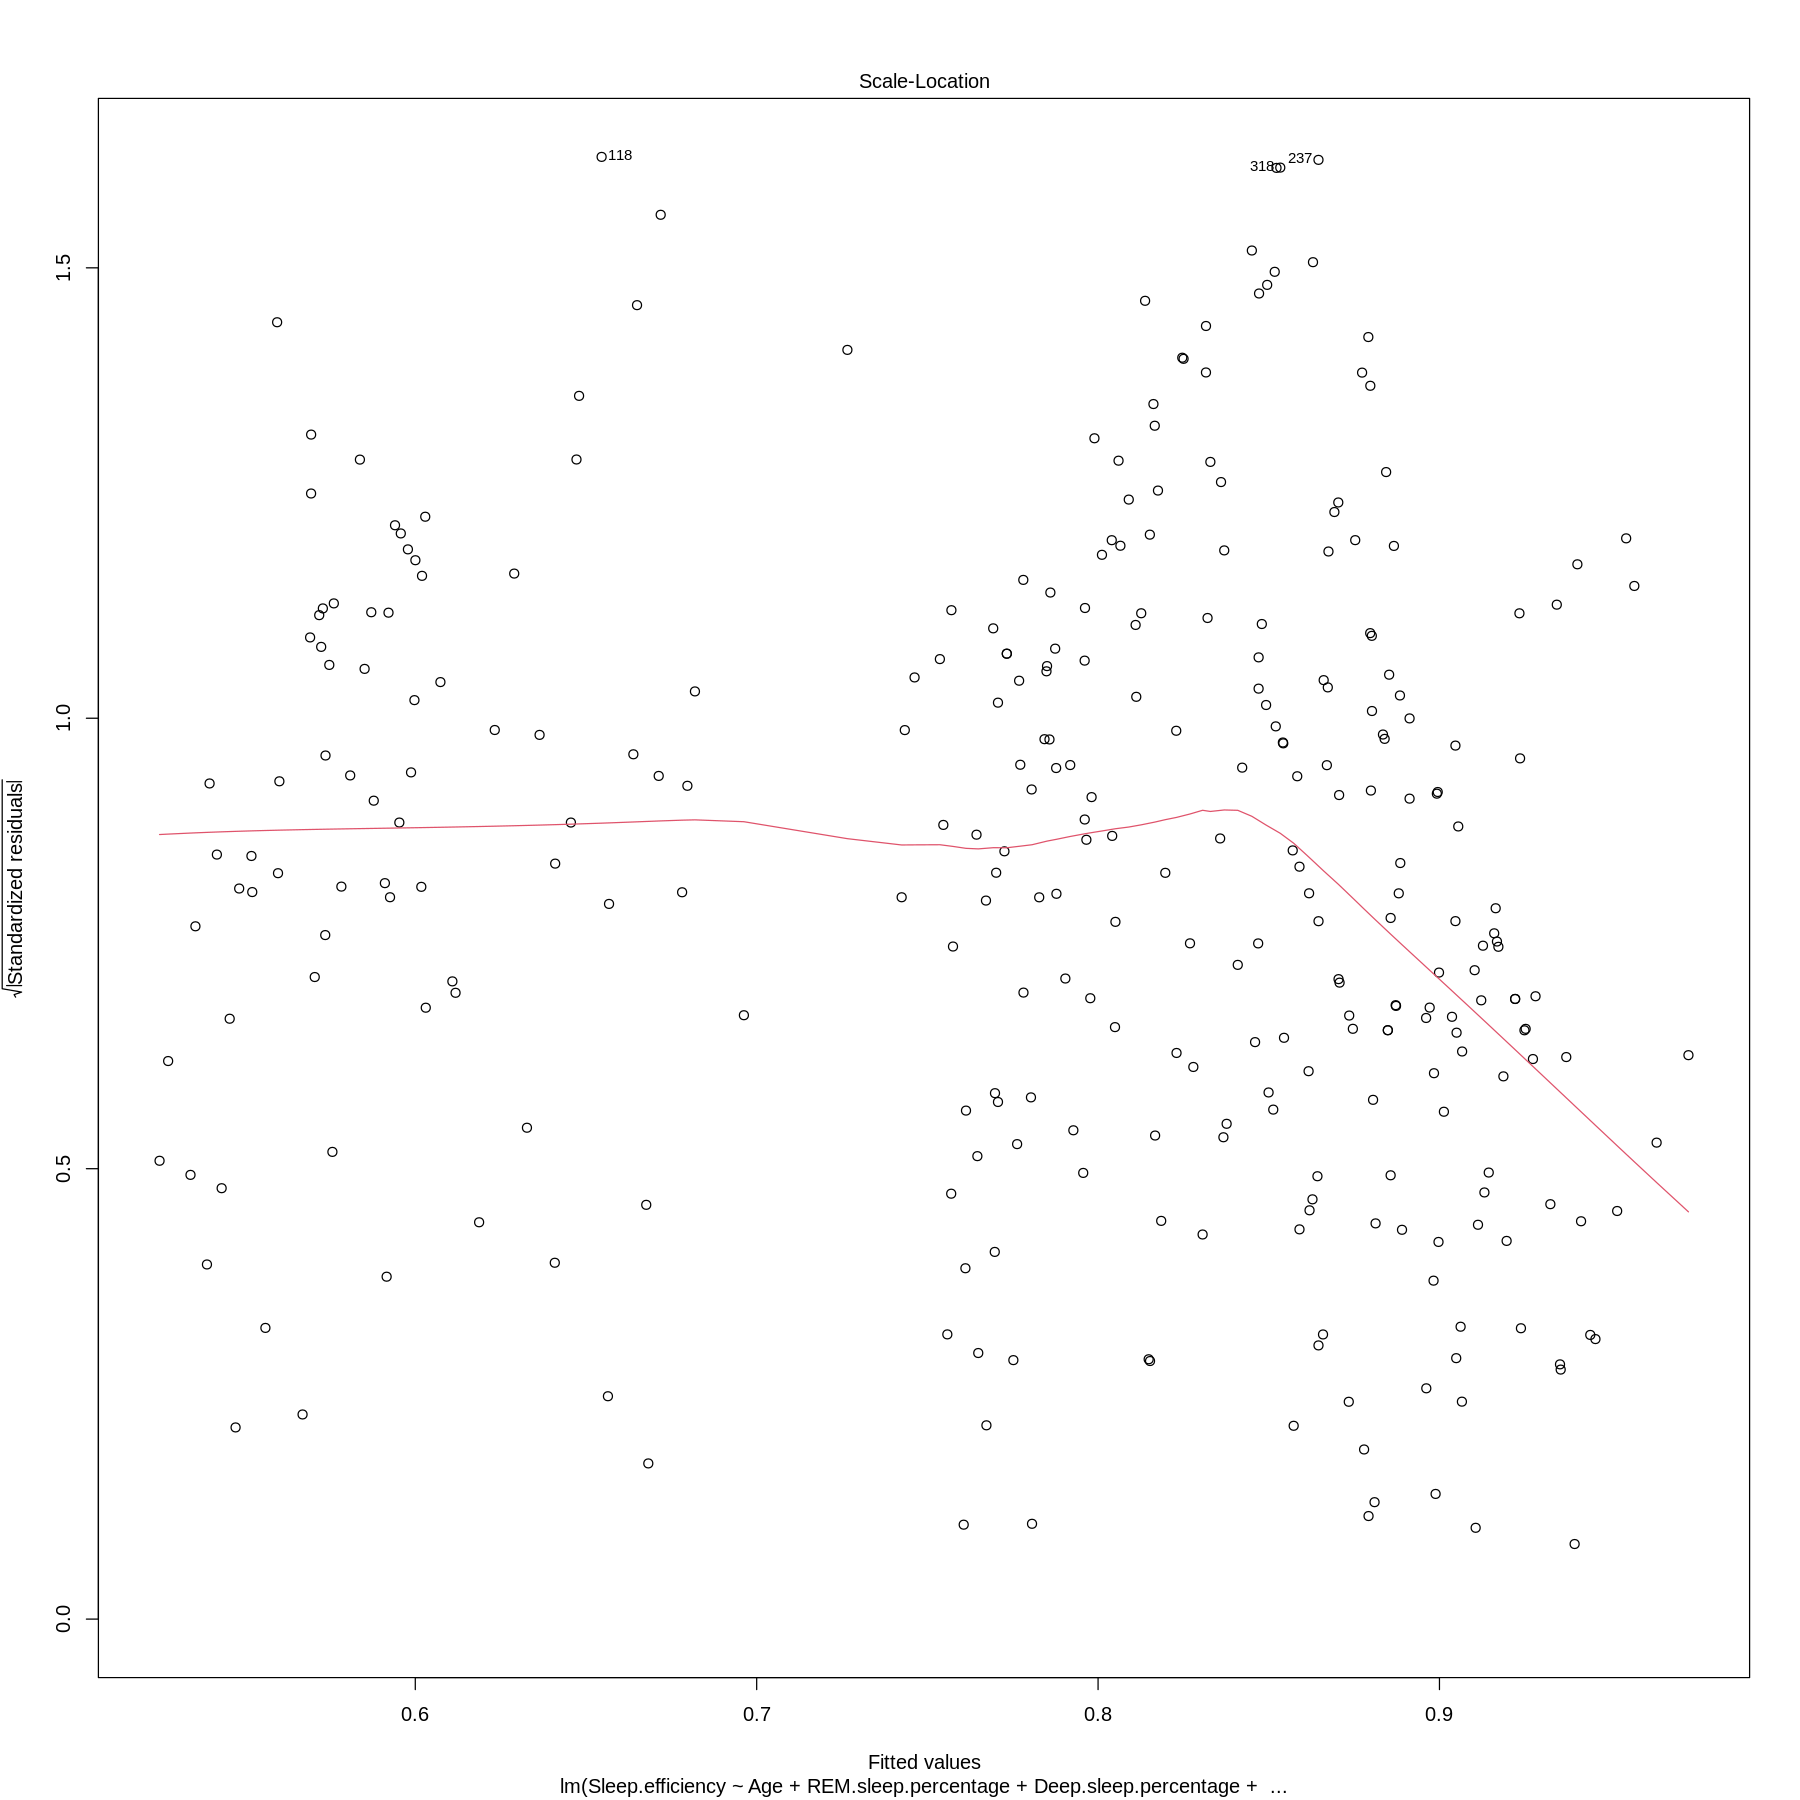

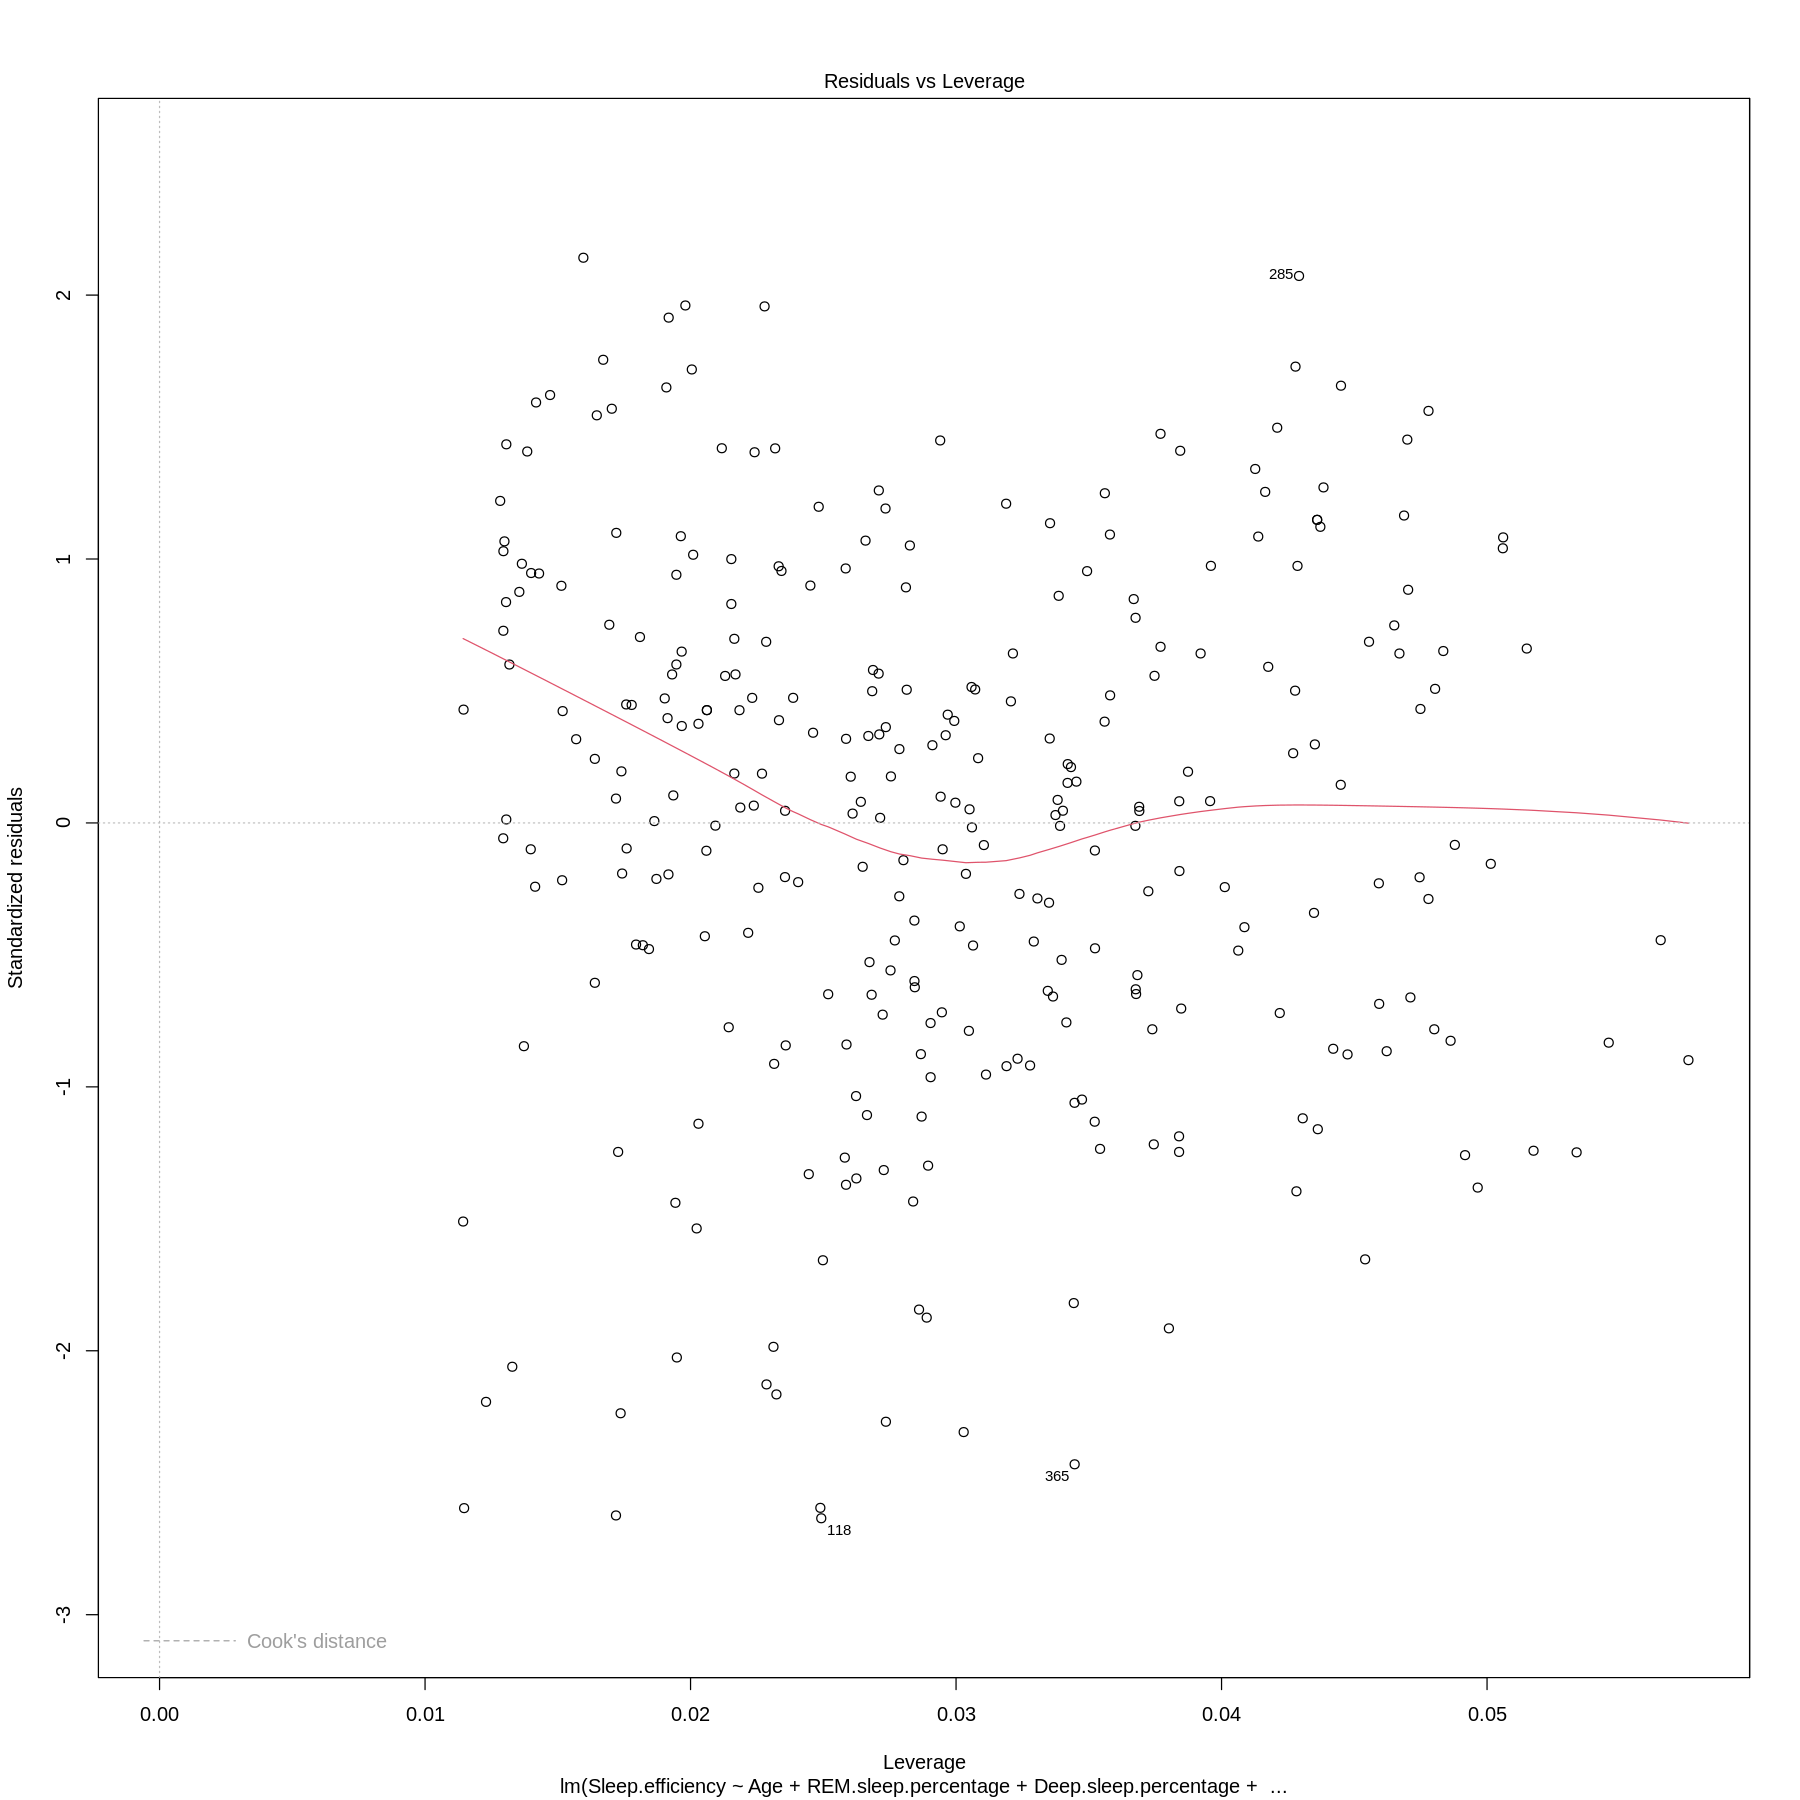

In [30]:
#Residual Plots and QQ plots for selected model:
plot(full_regression)
plot(sleep_selected_regression)

In [ ]:
#Interpretation about the plots:

In [ ]:
#If we look at the Residual plot, we can see there is no any obvious pattern exist and From the QQ plot. we see there exist a little  bit left skewed trend,
#but overall it is a good fitted model.

In [ ]:
#Compare our selected model with original full model, we forcus on the standardized residual plot and QQ plot,
#in the standardized residual of full regression model data appears to be unbalanced to the left side of it, but we did not see such kind of pattern in selected model.

In [ ]:
#Compare the QQ plots, we find that selected model is more approaching normal distribution since the points are concentrated more on the straight line if we compare with 
#the full regression model.

In [ ]:
#Conclusion: 

In [ ]:
#In summary, based on our linear regression model, we find that sleep efficency is closely related to people's age, REM.sleep.percentage, Deep.sleep.percentage, awakening times and Smoking.status.
#Before the research started, we expected the alcohol comsumption, exercise frequency and caffine comsumption would be the most important factors, but the result shows differet. However the age
#is also a factor that will increase the sleep efficiency is what we unexpected. The other exploratory variables come as no surprise, smoking and awakening will decrease you sleep efficency, and deep 
#sleep and REM sleep will give you a high quality sleep.